# Mini-project 2023 / CAETANO HUGO

This noteboook is my report for the image processing mini-project. Note that my complete coding experience and process is available in the `CaetanoTraitementImages.ipynb` notebook [here](https://colab.research.google.com/drive/1KgvWUjOMLnAkkqiG5Cl2sLE7b2-o00P5?usp=drive_link). The notebook you are consulting is a summarized version of my work, which acts as report of the project. 

You can find all the needed data in this [Drive](https://drive.google.com/drive/folders/1HwFTzHeOBc_wvqzbvt2xVk1SZiv3GPK9?usp=sharing). 

## About the project
The objective of this project is to clean a large quantity of corneal cell images, and then detect aggregates within them, in order to perform analyses on these aggregates to identify their area, perimeter, etc.

To achieve this, I will first clean all the images, and then utilize the model developed by Meta: Segment Anything Model. This model will allow me to identify the aggregates and extract their metrics. You can find information about this open-source model right here on [Meta's Github](https://github.com/facebookresearch/segment-anything/tree/main).

Ultimately, the idea is to generate and to plot some graphs to classify the aggregates based on these metrics (area, perimeter, etc.) and thereby study their distribution according to these various criteria.

> Note : I chose to work within a Google Colab environment because it enables me to get a better performance than when working locally, especially while working with the SAM model. 

> Note 2 : To avoid any RAM problem, I chose to work with 100 images. It wouldn't be much complicated to work with 200 or 300 images but I don't think that it adds that much to the work (in terms of difficulty at least).

## About how to test my code
- I imported the images of the mini-project on my google drive so that I could use them directly from Colab. But if you want to execute the code locally, you can just change the repository name. 

- I used the pickle library to generate **data checkpoints** throughout the process. This enables you to directly upload my mask object or the transformed images without having to compute it yourself. 

I will provide a little code chunk in order to load all the objects you need in the project. This chunk will be just at the beginning of **I**.

# I- Cleaning
First, let's get clean images to chew the job for SAM. Here, the methodology is straightforward: since the images are divided into two highly distinct halves with very different lighting levels, I will begin by smoothing the lighting using a mask on all the images.

## A- Initializing the coding environment

### 1- Useful libraries

In [1]:
import imageio.v2 as img #Reading images 
import matplotlib.pyplot as plt  # Display images
import os #accessing system files, etc.
import sys
from skimage import exposure  # Adjust contrast of images
import numpy as np  # Array manipulation
import pickle #storing and loading python variables from files
import gc #garbage collector -> freeing RAM easily

### 2- Google Drive
If you want to work directly from Collab and from the Drive, you can load your Drive data :

In [2]:
from google.colab import drive
drive.mount('/content/drive')
repo = "/content/drive/MyDrive/Projet_TB1/images" #will be useful to loop over the files later on.
%cd /content/drive/MyDrive/Projet_TB1/images

Mounted at /content/drive
/content/drive/MyDrive/Projet_TB1/images


Here is the magic chunk : 

In [6]:
with open('../mask.pkl', 'rb') as m: #mask used to clean my images
    mask = pickle.load(m)

with open('../images0_99.pkl', 'rb') as m: #the 100 images I exploited for my analysis (II)
    images = pickle.load(m)

with open('../masked0_99.pkl', 'rb') as m: #the 100 images I exploited for my analysis (II)
    tf_im = pickle.load(m)


I am not loading the SAM processed images because the `.pkl` file is too heavy and `pickle` cannot handle it...

## B- Masking
The images we have to process are pretty dirty, and the light is not homogoneous between their right part and their left part. In order to optimize my analysis, I will first apply a mask to uniformize the light over all the images. 

As a mask, we'll just compute the mean value of each pixel of all images. 

In [8]:
repo = '/content/drive/MyDrive/Projet_TB1/images'
mask = None
n = 0
# iterate over files in that directory
for filename in os.listdir(repo): #takes about 2min
    if "Exp2" in filename : #avoiding unwanted files -> bugs
      image_i = plt.imread(os.path.join(repo, filename))
    if mask is None:
        mask = np.zeros_like(image_i, dtype=np.float32) #else it is of type uint8 which doesn't support numbers > 255
    mask += image_i
    n += 1

mask /= n # divide by the number of images


Let's visualize our mask !

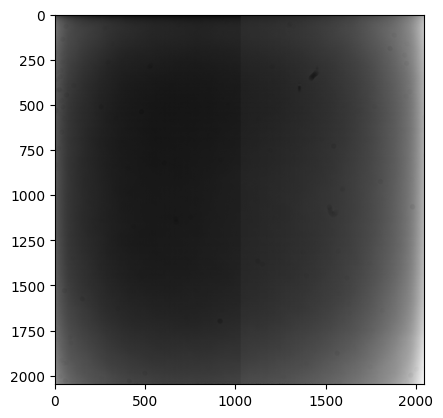

In [9]:
plt.imshow(np.round(mask).astype(np.uint8)) #for plt.imshow to work)
plt.show()

To apply our mask, we need two steps :
- substracting the mask to the image
- transform the result to fit in [0; 255]

In [10]:
first = images[0]
masked_first = first.astype(np.float32) - mask
masked_first -= masked_first.min()  #to get values between 0 and max + |min|
masked_first *= 255/masked_first.max() #to get values between 0 and 255

Let's visualize our new image ! 

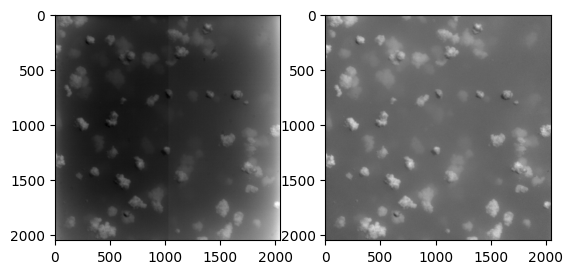

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(first)
plt.subplot(1, 2, 2)
plt.imshow(np.round(masked_first).astype(np.uint8))
plt.show()

Alright, I'm pretty happy with the mask. Let's apply it to our images now. 

# II - Getting those images cleaned

We have achieved a pretty cool mask that enables more or less uniform treatment on our picture. Let's just transform all our images with this mask.  


## A - Defining masking functions
First, let's define some clean functions.

> The masking function : It will enable us to mask one image

In [13]:
def sub_masker(image, mask) :
    image = image.astype(np.float32) - mask
    image -= image.min()  #to get values between 0 and max + |min|
    image *= 255/image.max() #to get values between 0 and 255
    return image
    

> The group masking function :
It will enable us to construct plenty of masked images at once

In [14]:
def big_masker(images, mask, N) :
    """
    This function returns the first N images of the images array after the action of a substractive mask.
    Note that the output will be of type float, so not directly plotable.
    """
    #i = 0 #To test my RAM limit
    masked = []
    if N > len(images) :
        for img_i in images :
          i+=1
          masked.append(sub_masker(img_i, mask))
          #print(i) #RAM limit test
    else :
        for img_i in images[:N] :
          i+=1
          #print(i) #RAM limit test
          masked.append(sub_masker(img_i, mask))
    return masked

## B- Cleaning operation 

Let's try it :

- Gathering some images. You already have 100 images in the `images.pkl` file. 

In [ ]:
#Preparing the loop
images = []
i = 1
repo = '/content/drive/MyDrive/Projet_TB1/images'
nb_images = 100

#Looping over the images in repo
for filename in os.listdir(repo):
    if(i > nb_images) : break #Avoiding too many images... Takes less than 4 seconds for 50 / 5000 -> no limit
    if "Exp2" in filename : #avoiding unwanted files -> bugs
      images.append(img.imread(os.path.join(repo, filename))) #path.join -> independence from OS !
      i += 1

Here is how the `big_masker` work :*texte en italique*

In [ ]:
tf_im = big_masker(images, mask, 5)

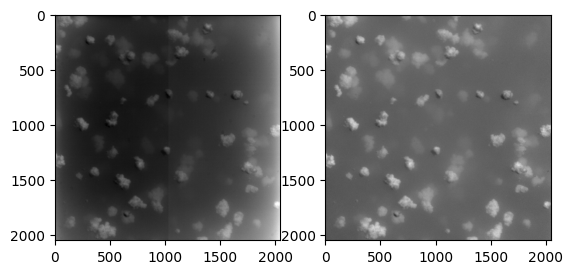

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(images[0].astype(np.uint8))
plt.subplot(1, 2, 2)
plt.imshow(tf_im[0].astype(np.uint8))
plt.show()

Nice ! It seems that we are ready to perform further aggregate detections. Let's begin with a little SAM test. SAM is a machine learning model trained by **Meta** to **"Segment Anything"**. Well let's see if its tittle is deserved. 

# III- SAM : Segment Anything (Meta)
Now that we can have clean images, let's see how well the SAM model from meta works to detect agregates on those clean images. 

To begin with, one must install `segment-anything` : `pip install git+https://github.com/facebookresearch/segment-anything.git`.

Let's set up our predictor. 

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [18]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam_checkpoint = "/content/drive/MyDrive/Projet_TB1/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

And let's try it over our images : 

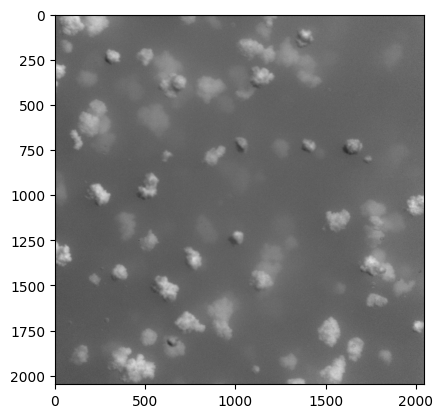

In [20]:
tf_im  = [item.astype(np.uint8) for item in tf_im] #appropriate format for plotting
testim = tf_im[0]
plt.imshow(testim)

Now let's do our first try : 

In [21]:
masks = mask_generator.generate(testim) #takes only 3s with Google Colab GPUs!

We can acces various pieces of information for each aggregate :

In [ ]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Let's try to visualize the result : 

In [22]:
def show_anns(anns): #This function is defined by Meta in their demo. 
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

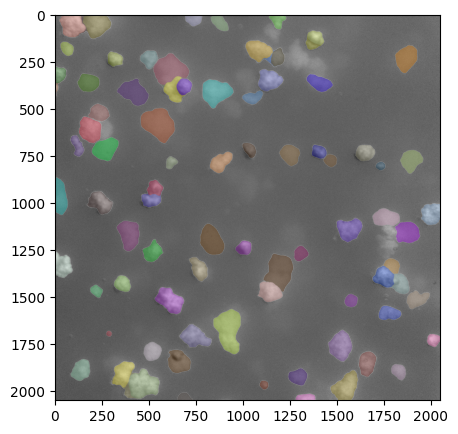

In [23]:
plt.figure(figsize=(5,5))
plt.imshow(testim)
show_anns(masks)
plt.show()

I tested the different SAM models to ensure that the model I was using wasn't too bad compared to the other ones (Meta grants access to various models, more or less heavy). Well, the big model detects many more segments, but the little model feels OK. I decided to use it because it enabled quicker computation...

# IV- Final computations

SAM will enable us to get the number of aggregates per image and the area of each one of these aggregates. To get an estimation of the perimeter of each aggregate, I'll use the `bbox` key from the mask objects. Indeed, it tells the coordinates of the smallest rectangle containing each aggregate. It is clearly not as good as having the perimeter, but in our case, computing the perimeter of this rectangle will give us a good idea of the repartition of aggregate perimeters. 

## A- Constructing the nb_particles array, the areas array and the perimeters array
Well, let's gather the data we need to plot some graphs. The construction of `SAM_masks` takes approximately 2.5 minutes. I would have liked to avoid you the computation time but I couldn't make the pickle file loading work... You can still try it : 


In [24]:
SAM_masks = [mask_generator.generate(item) for item in tf_im] # 2min for 100 images

> Reminder : There is a checkpoint for those masks 

In [ ]:
#Pickle loading
with open('../sam_masks.pkl', 'rb') as m :
  SAM_masks = pickle.load()

### 1- nb_particles
Getting the number of particles by image could enable us to see if there are specific cells containing way more (or way less) aggregates than the others. It could be the sign of cornea disease or anomaly I guess. 

In [25]:
nb_particles = [len(item) for item in SAM_masks] #nb of masks per image

### 3- areas and perimeters
The same goes for these two metrics. 

In [26]:
areas = []
for img in SAM_masks :
  for mask in img : 
    areas.append(mask['area'])

perimeters = []
for img in SAM_masks : 
  for mask in img :
    perimeters.append(2 * mask['bbox'][2] + mask['bbox'][3])

len(perimeters)

7679

We're working with 7679 aggregates. One problem that can ooccur with the SAM model is that it can identify the cell itself as a "segment". Then, we might have a problem of accuracy when counting those aggregates. Anyway, we're working with around 7600 aggregates for our analysis. 

# IV- Final plots
Well, let's plot our plots !

## Repartition of the number of aggregates per image

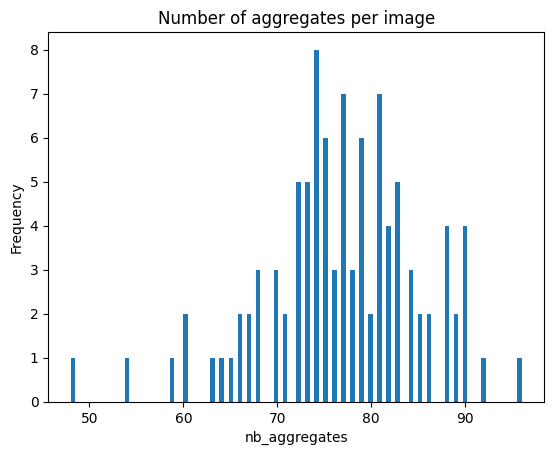

In [27]:
num_bins = len(nb_particles)

# Create the histogram
plt.hist(nb_particles, bins=num_bins)
plt.xlabel('nb_aggregates')
plt.ylabel('Frequency')
plt.title("Number of aggregates per image")
plt.show()

In [28]:
print(np.std(nb_particles), np.mean(nb_particles))

8.30216236892534 76.79


I could dig into the outliers a bit but globally, there is nothing shocking in this distribution. The standard deviation is around one eighth of the mean number of particles.

## Repartition of the areas of aggregates

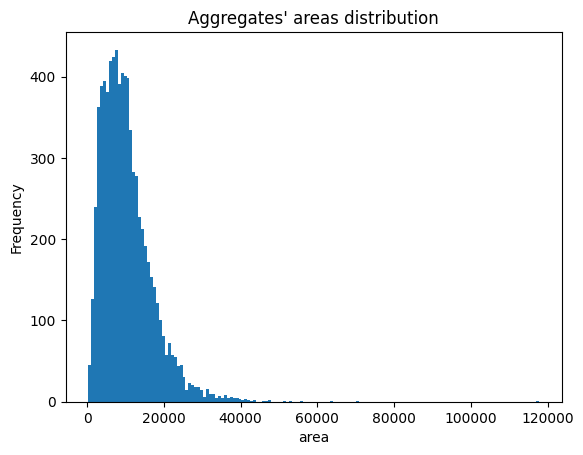

In [29]:
num_bins = len(areas) // 50 #1 bin = represents approximately 50 aggregates (mean)

# Create the histogram
plt.hist(areas, bins=num_bins)
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title("Aggregates' areas distribution")
plt.show()

There are many outliers with really big areas. The problem is that they harm the lisibility of the plot + they correspond to the SAM problem I was mentionning before. Let's get rid of those


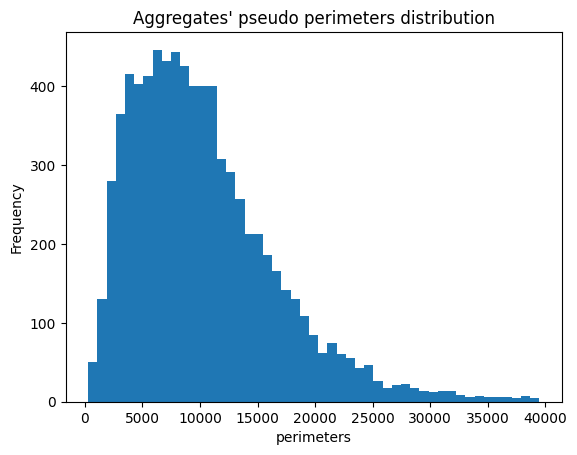

In [47]:
hist, bins = np.histogram(areas, bins='auto')
freq_tresh = 3
# Filter the bins based on the frequency threshold
filtered_bins = bins[:-1][hist > freq_tresh]
filtered_hist = hist[hist > freq_tresh]

# Create the histogram plot
plt.bar(filtered_bins, filtered_hist, width=np.diff(filtered_bins)[0], align='edge')

# Add labels and title
plt.xlabel('perimeters')
plt.ylabel('Frequency')
plt.title("Aggregates' pseudo perimeters distribution")

# Show the plot
plt.show()

This feels more lisible :)

## 3- perimeters
Let's do the same process for the pseudo perimeters : 

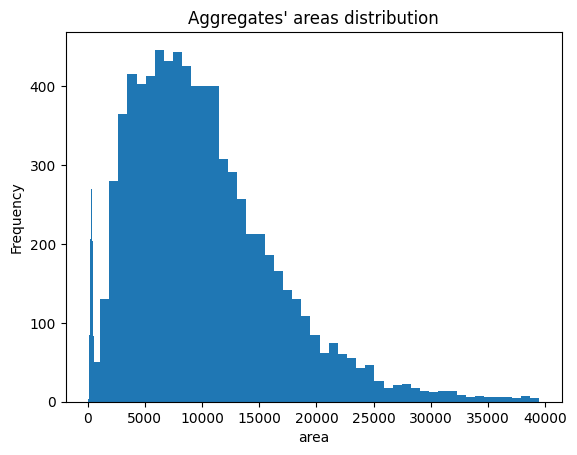

In [46]:
hist, bins = np.histogram(areas, bins='auto')
freq_tresh = 3
# Filter the bins based on the frequency threshold
filtered_bins = bins[:-1][hist > freq_tresh]
filtered_hist = hist[hist > freq_tresh]

# Create the histogram plot
plt.bar(filtered_bins, filtered_hist, width=np.diff(filtered_bins)[0], align='edge')

# Add labels and title
plt.hist(perimeters, bins=num_bins)
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title("Aggregates' areas distribution")

# Show the plot
plt.show()

## 4- To go further
To go further, I could use the value and not the frequency as a treshold. I could also use homemade methods to test the correlation between bbox perimeters and actual perimeters. 

# Thank you
I really hope you enjoy reading my work, and I thank you again for the time you gave me after the deadline ! I had a great time hiking in the Vosges, and I had a great time working on this practical work too. 

Hugo Caetano